In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 20000 # int(sys.argv[1])  # number of training steps
iteration = 5 # int(sys.argv[2])  # number of iterations (iid runs)
d = 20 # int(sys.argv[3])  # dimension of the distributions
mb_size = 4000 # int(sys.argv[4])  # batch size
N = 150000
rho_range = [0.1, 0.3, 0.5, 0.7, 0.9]
print(steps)
print(iteration)
print(d)
print(mb_size)
print(N)


20000
5
20
4000
150000


In [3]:
# hyperparameters
if d==4:
    layers = [d, 8, 8, 4, 1]
elif d==20:
    layers = [d, 32, 32, 16, 1]
elif d==50:
    layers = [d, 32, 32, 16, 1] # [d, 64, 64, 32, 1]
else:                      
    print('check dimension!')

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    out = 50.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 50.0) # bound M=50
    #out = 20.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 20.0)

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(rho_range), iteration)) 
RD_exact_rho =  np.zeros(shape= len(rho_range))


In [6]:

# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, rho in enumerate(rho_range): 
    
    print('j=', j)
    print('rho=', rho)
    
    # load data
    fname = 'data/varying_rho_Sigma1_eye_2/d_' + str(d) + '/input_N' + str(N) + '_dim' + str(d) + '/gaussian_d_' + str(d) + '_'
    data = scipy.io.loadmat(fname + 'data_'+str(rho)+'.mat')
    x_ = np.array(data['x'])
    y_ = np.array(data['y'])

    params = scipy.io.loadmat(fname + 'params_'+str(rho)+'.mat')
    alpha = np.array(params['alpha'])
    No_alpha = alpha.shape[0]

    RD_exact = np.array(params['RD_exact']) # contains exact for all alphas. In current datafiles, only one

    
    beta = lam*(1-alpha[0])  #   <----------- choose the first alpha value
    gamma = lam*alpha[0]  #  <---------- choose the first alpha value
    
    #exact value for Renyi (estimated by integral computation)
    RD_exact_rho[j] = RD_exact[0];
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake
    total_loss = D_loss

    #D_solver = tf.train.AdamOptimizer().minimize(total_loss, var_list=theta_D)
    D_solver = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())

        x = x_[np.random.randint(x_.shape[0], size=int(0.8*x_.shape[0])), :]
        y = y_[np.random.randint(y_.shape[0], size=int(0.8*x_.shape[0])), :]

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_gaussian_BS_plots/'):
        os.makedirs('data/out_gaussian_BS_plots/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_gaussian_BS_plots/cgan_Dloss' + str(j) + 'rho_' + str(rho) +'.png', bbox_inches='tight')
    plt.close(fig)
   


j= 0
rho= 0.1
Iteration: 0
Iter: 0
Renyi divergence: [5.948241e-06]

Iter: 1000
Renyi divergence: [0.03277963]

Iter: 2000
Renyi divergence: [0.04846442]

Iter: 3000
Renyi divergence: [0.04997057]

Iter: 4000
Renyi divergence: [0.04849362]

Iter: 5000
Renyi divergence: [0.04806447]

Iter: 6000
Renyi divergence: [0.05071396]

Iter: 7000
Renyi divergence: [0.0527342]

Iter: 8000
Renyi divergence: [0.0478912]

Iter: 9000
Renyi divergence: [0.05525959]

Iter: 10000
Renyi divergence: [0.05735946]

Iter: 11000
Renyi divergence: [0.05113721]

Iter: 12000
Renyi divergence: [0.06852144]

Iter: 13000
Renyi divergence: [0.07203692]

Iter: 14000
Renyi divergence: [0.06458533]

Iter: 15000
Renyi divergence: [0.05913532]

Iter: 16000
Renyi divergence: [0.06499529]

Iter: 17000
Renyi divergence: [0.06094933]

Iter: 18000
Renyi divergence: [0.05012548]

Iter: 19000
Renyi divergence: [0.08325744]

Iteration: 1
Iter: 0
Renyi divergence: [1.3983808e-06]

Iter: 1000
Renyi divergence: [0.03545463]

Iter: 2

Iter: 6000
Renyi divergence: [0.47388315]

Iter: 7000
Renyi divergence: [0.48836756]

Iter: 8000
Renyi divergence: [0.52512765]

Iter: 9000
Renyi divergence: [0.44016266]

Iter: 10000
Renyi divergence: [0.48768973]

Iter: 11000
Renyi divergence: [0.4729774]

Iter: 12000
Renyi divergence: [0.5090692]

Iter: 13000
Renyi divergence: [0.4663124]

Iter: 14000
Renyi divergence: [0.51054907]

Iter: 15000
Renyi divergence: [0.5043826]

Iter: 16000
Renyi divergence: [0.48508048]

Iter: 17000
Renyi divergence: [0.47246552]

Iter: 18000
Renyi divergence: [0.44789147]

Iter: 19000
Renyi divergence: [0.49710846]

j= 2
rho= 0.5
Iteration: 0
Iter: 0
Renyi divergence: [-4.3748878e-07]

Iter: 1000
Renyi divergence: [1.532731]

Iter: 2000
Renyi divergence: [1.549201]

Iter: 3000
Renyi divergence: [1.5885801]

Iter: 4000
Renyi divergence: [1.480236]

Iter: 5000
Renyi divergence: [1.5482578]

Iter: 6000
Renyi divergence: [1.5359619]

Iter: 7000
Renyi divergence: [1.5675242]

Iter: 8000
Renyi divergence: [

Iter: 16000
Renyi divergence: [4.1273317]

Iter: 17000
Renyi divergence: [4.3093314]

Iter: 18000
Renyi divergence: [4.2152643]

Iter: 19000
Renyi divergence: [4.322838]

Iteration: 4
Iter: 0
Renyi divergence: [9.998796e-06]

Iter: 1000
Renyi divergence: [3.8121085]

Iter: 2000
Renyi divergence: [4.096272]

Iter: 3000
Renyi divergence: [4.006959]

Iter: 4000
Renyi divergence: [3.8628006]

Iter: 5000
Renyi divergence: [4.029401]

Iter: 6000
Renyi divergence: [4.2247705]

Iter: 7000
Renyi divergence: [4.1109266]

Iter: 8000
Renyi divergence: [4.183007]

Iter: 9000
Renyi divergence: [4.1459656]

Iter: 10000
Renyi divergence: [4.330798]

Iter: 11000
Renyi divergence: [4.2226787]

Iter: 12000
Renyi divergence: [4.223384]

Iter: 13000
Renyi divergence: [4.2962384]

Iter: 14000
Renyi divergence: [4.167506]

Iter: 15000
Renyi divergence: [3.924468]

Iter: 16000
Renyi divergence: [4.1959424]

Iter: 17000
Renyi divergence: [3.9882703]

Iter: 18000
Renyi divergence: [4.1005397]

Iter: 19000
Renyi

In [7]:
print(D_loss_vals)

[[ 0.06269729  0.06134295  0.05860269  0.06062627  0.07237661]
 [ 0.50421715  0.49409938  0.50221109  0.49487972  0.49679375]
 [ 1.60348654  1.63435555  1.61609459  1.62704039  1.62439775]
 [ 4.20348883  4.2254653   4.12557554  4.1853199   4.20014286]
 [13.1714859  12.96992588 13.41431046 13.13113117 13.28240013]]


In [8]:
   

with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(rho)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)


Text(0, 0.5, 'divergence')

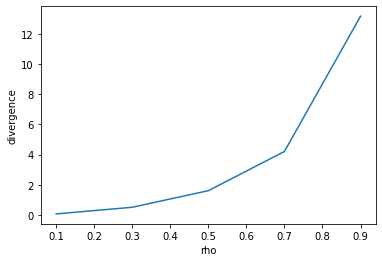

In [9]:
# Plot RD vs rho
#======================
fig = plt.figure()
plt.plot(rho_range, D_loss_vals[:,0])
plt.xlabel('rho')
plt.ylabel('divergence')

(0.0, 14.0)

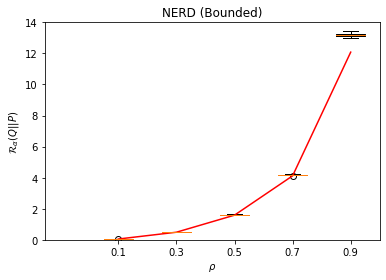

In [10]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Bounded)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0.1, 0.3, 0.5, 0.7, 0.9], whis=2)
ax1.plot(np.arange(1,len(rho_range)+1), RD_exact_rho[:],'r', 'LineWidth', 2 );
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.0, 14.0)




In [ ]:
print('program terminated succesfully')